## This is for the exam project


In [26]:
##Imports
from time import sleep
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from bs4 import BeautifulSoup as soup
import bs4
import requests
import re
import sys

### Numberplate to string without img handling

In [51]:
import cv2
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'
#pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/Cellar/tesseract/4.1.1/bin/tesseract'
img = cv2.imread("./images/test3.jpg")
text = pytesseract.image_to_string(img)
print(text)


### Numberplate to string

Nummerpladen er: 


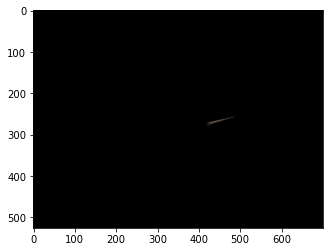

In [61]:
import cv2
import imutils
import numpy as np
from matplotlib import pyplot as plt
import pytesseract
#Windows
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

#M1
#pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/Cellar/tesseract/4.1.1/bin/tesseract'

#Import image and resize it
img = cv2.imread('./images/test3.jpg', cv2.IMREAD_COLOR)
img = imutils.resize(img, width=700)

#Gray scale 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Blur to reduce noise
gray = cv2.bilateralFilter(gray, 13, 15, 15)

#Edge detection
edged = cv2.Canny(gray, 30, 200)

contours = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
screenCnt = None

#Find contours in the edged image
(cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30]

NumberPlateCnt = None 
count = 0
#Loop over contours
for c in cnts:
	#Approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    #If the approximated contour has four points, then assume that screen is found
    if len(approx) == 4:  
        NumberPlateCnt = approx 
        break

#Mask the part other than the numberplate
mask = np.zeros(gray.shape,np.uint8)
new_image = cv2.drawContours(mask,[NumberPlateCnt],0,255,-1)
new_image = cv2.bitwise_and(img,img,mask=mask)

#Crop the image 
(x, y) = np.where(mask == 255)
(topx, topy) = (np.min(x), np.min(y))
(bottomx, bottomy) = (np.max(x), np.max(y))
Cropped = gray[topx:bottomx+1, topy:bottomy+1]

#Read the number plate
config = ('-l eng --oem 1 --psm 3')
text = pytesseract.image_to_string(Cropped, config=config)
print("Nummerpladen er:",text)
plt.imshow(new_image)

cv2.waitKey(0)
cv2.destroyAllWindows()

### Entering numberplate on nummerplade.net to find model

In [28]:
print("Starting up..")
profile = webdriver.FirefoxProfile()
profile.set_preference("general.useragent.override", "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:81.0) Gecko/20100101 Firefox/81.0")
options = Options()
options.headless = True

#M1
#browser = webdriver.Chrome(executable_path="/Users/frederikdahl/chromedriver/chromedriver")

#Windows
browser = webdriver.Firefox(options=options)

browser.get("https://www.nummerplade.net/")

print("Got Browser")

browser.implicitly_wait(3)

#cookie_button = browser.find_element_by_css_selector('div.coi-banner__page-footer:nth-child(2) > button:nth-child(2)')
#cookie_button.click()
#print("Cookie Button Clicked..")
#sleep(3) 

search_field = browser.find_element_by_id('search_regnr')

search_field.send_keys(text)

button = browser.find_element_by_id('search_regnr_button')
button.click()
print("Search Entered")
sleep(3)

print()

page_source = browser.page_source
page_soup = soup(page_source,'html.parser')
res = page_soup.select_one("#maerke").text +" "+ page_soup.select_one("#model").text + ""

print("Mærke/model på søgte bil: ", res)
browser.quit()

Starting up..
Got Browser
Search Entered

Søgte bil:  Toyota Aygo


### Searching for model on bilbasen to get model,price,km, 

In [45]:
base_url = 'https://www.bilbasen.dk/'

class my_car:
    def __init__(self, url):
        self.base_url = url
        self.car_list = []
        
        print("Starting up...")
        
        profile = webdriver.FirefoxProfile()
        profile.set_preference("general.useragent.override", "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:81.0) Gecko/20100101 Firefox/81.0")
        options = Options()
        options.headless = True
        
        #Windows
        self.browser = webdriver.Firefox(options=options)
        
        #M1 
        #self.browser  = webdriver.Chrome(executable_path="/Users/frederikdahl/chromedriver/chromedriver")
        
        self.browser.get(self.base_url)
        print("Got Browser")
        
        self.browser.implicitly_wait(3)
        
    def click_cookie_button(self):
        try:
            cookie_button = self.browser.find_element_by_id('onetrust-accept-btn-handler')
            try:
                cookie_button.click()
                print("Cookie Button Clicked")
                sleep(3)   
            except Exception as err:
                print('Error With Cookie Button:', err)
        except Exception as err:
            print(err)
            
    def click_leasing_button(self):
        try:
            leasing_button = self.browser.find_element_by_css_selector("label[data-track-action='leasing-toggle']")
            try:
                leasing_button.click()
                print("Leasing Button Clicked")
                sleep(3)   
            except Exception as err:
                print('Error With Leasing Button:', err)
        except Exception as err:
            print(err)
        
    def search_in_search_bar(self, search_text):
        try:
            search_field = self.browser.find_element_by_class_name('react-autosuggest__input')
            search_field.send_keys(search_text)
            search_field.submit()
            print("Search Bar Entered")
            sleep(3)

        except Exception as err:
            print('Error with Search', err)

    def get_car_list(self):
        print("Souping Site")
        print()
        page_source = self.browser.page_source
        page_soup = soup(page_source,'html.parser')
        car_list_plus = page_soup.findAll("div",{"class":"row listing listing-plus bb-listing-clickable"})
        car_list_discount = page_soup.findAll("div",{"class":"row listing listing-discount bb-listing-clickable"})
        full_list = car_list_plus + car_list_discount
        print("Cars found: " + str(len(full_list)))
        for car in full_list:
            name = car.find("a",{"class":"listing-heading darkLink"}).contents[0]
            km = int(car.findAll("div",{"class":"col-xs-2 listing-data"})[1].contents[0].replace('.',''))
            price = car.find("div",{"class":"col-xs-3 listing-price"}).contents[0].replace(' kr.','').replace('.','')
            year = int(car.findAll("div",{"class":"col-xs-2 listing-data"})[2].contents[0])
            car_info = {"name": name, "km": km, "price": price, "year": year}
            self.car_list.append(car_info)
            print(car_info) 
            
    def close_browser(self):
        self.browser.close()
    
bilbasen = my_car(base_url)
bilbasen.click_cookie_button()
bilbasen.click_leasing_button()
bilbasen.search_in_search_bar(res)
print("Searching for: " + res)
bilbasen.get_car_list()
bilbasen.close_browser()
make_me_dataframe = bilbasen.car_list

Starting up...
Got Browser
Cookie Button Clicked
Leasing Button Clicked
Search Bar Entered
Searching for: Toyota Aygo
Souping Site

Cars found: 32
{'name': 'Toyota Aygo 1,0 VVT-i x 5d', 'km': 35000, 'price': '87900', 'year': 2018}
{'name': 'Toyota Aygo 1,0 VVT-i x-wave Sky 5d', 'km': 81700, 'price': '72900', 'year': 2015}
{'name': 'Toyota Aygo 1,0 VVT-i x 5d', 'km': 91000, 'price': '54900', 'year': 2015}
{'name': 'Toyota Aygo 1,0 VVT-i T2 Air 5d', 'km': 141000, 'price': '39500', 'year': 2012}
{'name': 'Toyota Aygo 1,0 VVT-i x-press 5d', 'km': 2000, 'price': '106900', 'year': 2020}
{'name': 'Toyota Aygo 1,0 VVT-i x-press 5d', 'km': 0, 'price': '111990', 'year': 2020}
{'name': 'Toyota Aygo 1,0 VVT-i x-press 5d', 'km': 57000, 'price': '64900', 'year': 2015}
{'name': 'Toyota Aygo 1,0 VVT-i x-sky 5d', 'km': 69000, 'price': '74900', 'year': 2015}
{'name': 'Toyota Aygo 1,0 VVT-i x-press 5d', 'km': 78000, 'price': '64900', 'year': 2016}
{'name': 'Toyota Aygo 1,0 VVT-i x-plore x-shift 5d', 'km'

In [47]:
import pandas as pd

# Import the data into a Pandas dataframe 
data = pd.DataFrame(make_me_dataframe)
# Show the head of the dataframe 
data.head()

,name,km,price,year
0,"Toyota Aygo 1,0 VVT-i x 5d",35000,87900,2018
1,"Toyota Aygo 1,0 VVT-i x-wave Sky 5d",81700,72900,2015
2,"Toyota Aygo 1,0 VVT-i x 5d",91000,54900,2015
3,"Toyota Aygo 1,0 VVT-i T2 Air 5d",141000,39500,2012
4,"Toyota Aygo 1,0 VVT-i x-press 5d",2000,106900,2020


In [48]:
from sklearn import preprocessing
import sklearn.linear_model


#Remove outliers fra data (dataFrame)

#Hint ???: df[column name'] < df['column name'].quantile(0.90)
#outliers = gasoline[gasoline] < dataFrame['Fuel Information.Fuel Type'].quantile(0.90)

## Remove outliers 


## 

#Only use 2 features : 'Fuel Information.Highway mpg' and 'Engine Information.Engine Statistics.Horsepower'

features = data[['km', 'year']]


#Normalize data (reduce values to be between 0 and 1)
scaler = preprocessing.MinMaxScaler()
names = features.columns
d = scaler.fit_transform(features)
scaled_df = pd.DataFrame(d, columns=names)
scaled_df.head()



,km,year
0,0.159091,0.857143
1,0.371364,0.642857
2,0.413636,0.642857
3,0.640909,0.428571
4,0.009091,1.000000


Coef:  [-0.72047019]
The coef contain the coefficients for the prediction of each of the targets.
When X = 1, Y will be 0.17707378383201833 according to our model 


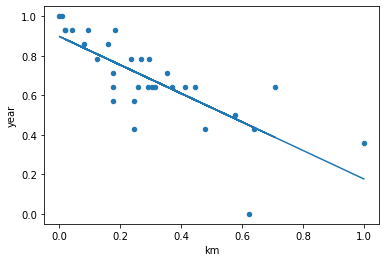

In [49]:
# Perform linear regression where x = horsepower and y = mpg

xs = scaled_df['km']
ys = scaled_df['year']

xs_reshape = np.array(xs).reshape(-1, 1)

model = sklearn.linear_model.LinearRegression()
model.fit(xs_reshape, ys)

# What is the coefficient (slope) of your model? What does this number mean? 
print("Coef: ", model.coef_ , )
print("The coef contain the coefficients for the prediction of each of the targets.")

# According to your model, what is y when x=1. 
predicted = model.predict(xs_reshape)
xwheny1 = model.predict([[1]])
print('When X = 1, Y will be {} according to our model '.format(xwheny1[0]))

# Show the regression line on a scatterplot with the other datapoints.
scaled_df.plot.scatter(x = 0, y = 1)

m, b = np.polyfit(xs, ys, 1)
plt.plot(xs, m*xs + b)




In [50]:
# Denomalisere data og få en værdi ud 

# Funktionalitet til at få pris ud fra modellen 
# Model.predict() 

model.predict([[2012,100000]])



#unscaled = scaler.inverse_transform(scaled_df)
#print(unscaled)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)